**Simon Mekonnen  
UGR/9508/12**

In this notebook, I implement a binary image classification model using PyTorch. The goal of the model is to classify chest X-ray images into two classes: "Normal" and "Tuberculosis." The dataset used for training and testing contains images from the TB Chest Radiography Database.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
root_folder = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/'

The image transformation is composed of the following operations

In [3]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((250, 250)),  # Resize to a consistent size
    transforms.ToTensor()  # Convert to PyTorch tensor
])

In [4]:
# Load dataset using torchvision.datasets.ImageFolder
binary_dataset = datasets.ImageFolder(root=root_folder, transform=transform)

In [5]:
# Creating a DataLoader for the binary dataset
data_loader = DataLoader(binary_dataset, batch_size=64, shuffle=True)

In [6]:
# Accessing labels and images
for inputs, labels in data_loader:
    print(f'Input shape: {inputs.shape}, Label shape: {labels.shape}')
    break 
    

Input shape: torch.Size([64, 1, 250, 250]), Label shape: torch.Size([64])


<font size = 4>I used 80% of the data for training and 20% of the data for validation</font>

In [7]:
train_size = int(0.8 * len(binary_dataset))
val_size = len(binary_dataset) - train_size

In [8]:
# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(binary_dataset, [train_size, val_size])


# Custom CNN Model for Binary Image Classification

The `CustomCNN` model is designed for binary image classification, particularly for distinguishing between two classes. Below is a breakdown of its architecture:

### Convolutional Layers:
- **Convolutional Layer 1:** 1 input channel, 32 output channels, 3x3 kernel, padding of 1, followed by ReLU activation.
- **Convolutional Layer 2:** 32 input channels, 32 output channels, 3x3 kernel, padding of 1, followed by ReLU activation.
- **MaxPooling Layer:** 2x2 kernel with a stride of 2 for downsampling.
- This pattern repeats with variations in channel configurations.

### Fully Connected Layers:
- **Flattening Layer:** Transforms the 3D tensor into a 1D tensor.
- **Linear Layer 1:** Input size of 128 * 31 * 31, output size of 128, followed by ReLU activation.
- **Linear Layer 2:** Input size of 128, output size of 1 for binary classification.
- **Sigmoid Activation:** Applied to the output for binary classification probability.

### Forward Pass:
The `forward` method passes input data through the convolutional and fully connected layers, producing the final output.

In [9]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 31 * 31, 128),
            nn.ReLU(),
            nn.Linear(128, 1),  # Output layer with 1 neuron for binary classification
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Training and Plotting Function

## Parameters
- `learning_rate`: The learning rate for the optimizer.
- `batch_size`: The batch size for DataLoader during training and validation.
- `epochs`: The number of epochs for training.

## Model Initialization
- Create an instance of the `CustomCNN` model.

## DataLoaders
- Create DataLoader objects for training and validation datasets with the specified batch size.

## Optimizer and Loss Function
- Use Adam optimizer with the given learning rate.
- Use Binary Cross Entropy Loss (`BCELoss`) since it's a binary classification task.

## Training Loop
- Loop through the specified number of epochs.
- Set the model to training mode.
- Perform forward pass, calculate loss, backward pass, and optimizer step for each batch in the training set.
- Keep track of running loss for each epoch.

## Validation Loop
- Set the model to evaluation mode.
- Perform forward pass for each batch in the validation set, calculate loss, and evaluate accuracy.
- Keep track of validation loss and accuracy.

## Plotting
- Plot training and validation losses over epochs in one subplot.
- Plot validation accuracy over epochs in another subplot.


In [10]:
def train_and_plot(learning_rate, batch_size, epochs,save_path):
    
    #Create a model 
    model = CustomCNN()
    # Create DataLoaders for training and validation sets with the specified batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Define the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification

    # Lists to store training history
    train_losses = []
    val_losses = []
    accuracies = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.float().view(-1, 1))
                val_loss += loss.item()

                # Convert outputs to binary predictions (0 or 1)
                predictions = torch.round(outputs)
                total += labels.size(0)
                correct += (predictions == labels.float().view(-1, 1)).sum().item()

        accuracy = (correct / total) * 100
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        # Append values to lists for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        accuracies.append(accuracy)

        print(f'Epoch {epoch + 1}/{epochs}, Avg. Training Loss: {avg_train_loss}, Avg. Validation Loss: {avg_val_loss}, Accuracy: {accuracy}%')
        
        
    torch.save(model.state_dict(), save_path)
    # Plotting
    plt.figure(figsize=(10, 5))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Model Experiment Results Model 1

- **Configuration:** LR=0.001, Batch=64, Epochs=1
- **Training Loss:** 0.42, **Validation Loss:** 0.28
- **Validation Accuracy:** 89.4%

Results for one epoch with specific hyperparameters. Further experimentation may optimize performance.

Epoch 1/1, Avg. Training Loss: 0.4150080995739631, Avg. Validation Loss: 0.2762061506509781, Accuracy: 89.40476190476191%


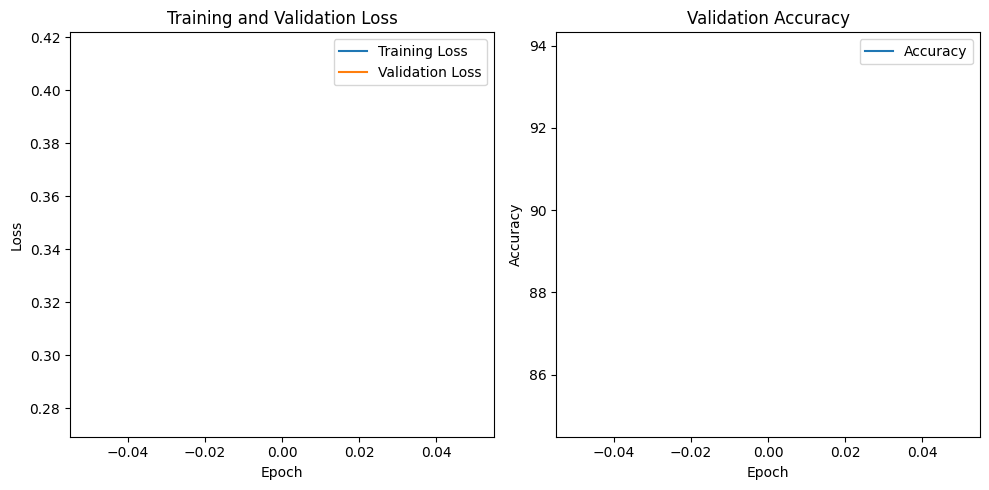

In [13]:
train_and_plot(learning_rate=0.001, batch_size=64, epochs=1,save_path = "/kaggle/working/model_1.pth")

# Model Experiment Results Model 2

- **Configuration:** LR=0.001, Batch=64, Epochs=2
- **Epoch 1:**
  - **Training Loss:** 0.38, **Validation Loss:** 0.23
  - **Validation Accuracy:** 90.9%%
- **Epoch 2:**
  - **Training Loss:** 0.22, **Validation Loss:** 0.13
  - **Validation Accuracy:** 94.52%

Results after two epochs of training with specified hyperparameters. Notable improvement in accuracy during the second epoch.


Epoch 1/2, Avg. Training Loss: 0.3875762390078239, Avg. Validation Loss: 0.23010709722127234, Accuracy: 90.83333333333333%
Epoch 2/2, Avg. Training Loss: 0.21902196344761354, Avg. Validation Loss: 0.12878117790179594, Accuracy: 94.52380952380952%


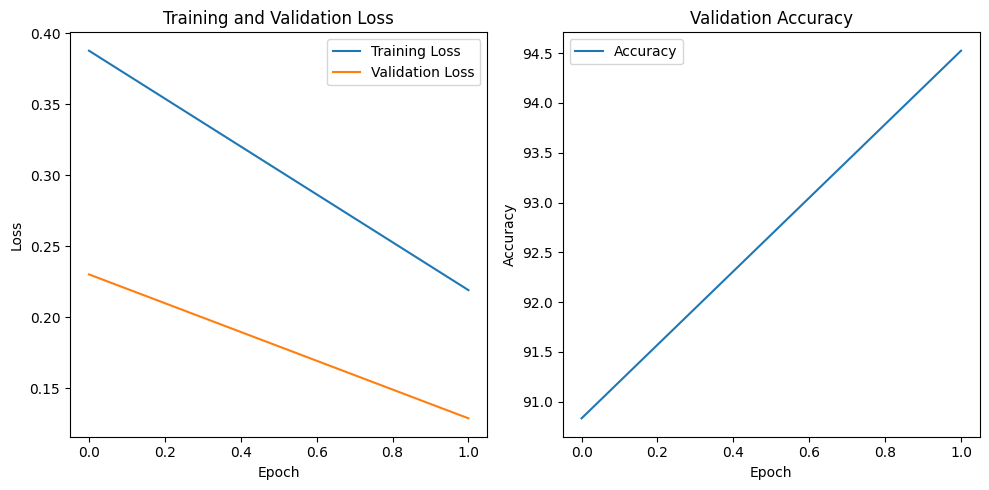

In [14]:
train_and_plot(learning_rate=0.001, batch_size=64, epochs=2,save_path = "/kaggle/working/model_2.pth")

# Model Experiment Results Model 3

- **Configuration:** LR=0.001, Batch=64, Epochs=5
- **Epoch 1:**
  - **Training Loss:** 0.43, **Validation Loss:** 0.28
  - **Validation Accuracy:** 89.5%
- **Epoch 2:**
  - **Training Loss:** 0.23, **Validation Loss:** 0.13
  - **Validation Accuracy:** 94.00%
- **Epoch 3:**
  - **Training Loss:** 0.16, **Validation Loss:** 0.09
  - **Validation Accuracy:** 96.43%
- **Epoch 4:**
  - **Training Loss:** 0.11, **Validation Loss:** 0.07
  - **Validation Accuracy:** 97.5%
- **Epoch 5:**
  - **Training Loss:** 0.11, **Validation Loss:** 0.08
  - **Validation Accuracy:** 96.90%

Results after five epochs of training with specified hyperparameters. Noticeable improvement in accuracy with each epoch.


Epoch 1/5, Avg. Training Loss: 0.42588373372014965, Avg. Validation Loss: 0.27669100889137815, Accuracy: 89.52380952380953%
Epoch 2/5, Avg. Training Loss: 0.22588631510734558, Avg. Validation Loss: 0.13304164792810166, Accuracy: 93.92857142857143%
Epoch 3/5, Avg. Training Loss: 0.1607963961531531, Avg. Validation Loss: 0.08960580100704517, Accuracy: 96.42857142857143%
Epoch 4/5, Avg. Training Loss: 0.11392774014681015, Avg. Validation Loss: 0.0723387427860871, Accuracy: 97.5%
Epoch 5/5, Avg. Training Loss: 0.10887382202342434, Avg. Validation Loss: 0.086630564582135, Accuracy: 96.9047619047619%


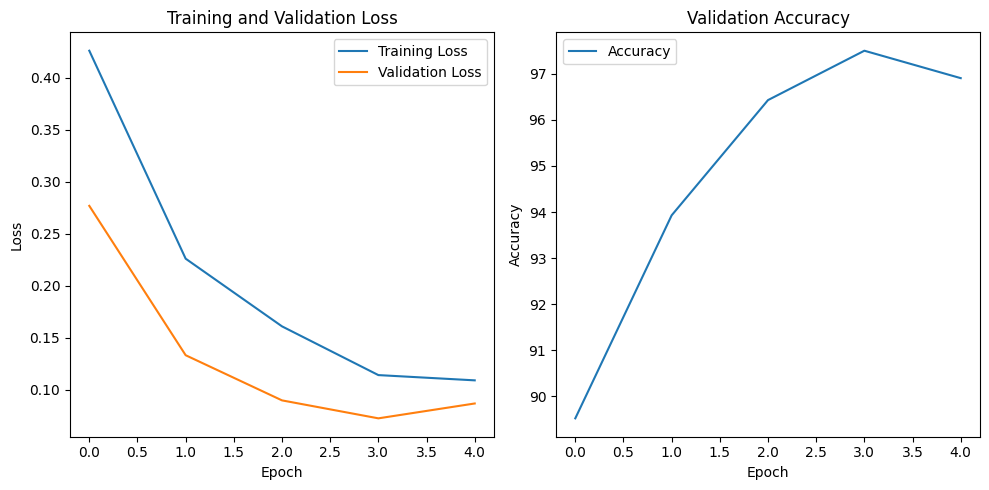

In [15]:
train_and_plot(learning_rate=0.001, batch_size=64, epochs=5,save_path = "/kaggle/working/model_3.pth")

# Model Experiment Results Model 4

- **Configuration:** LR=0.1, Batch=64, Epochs=1
- **Epoch 1:**
  - **Training Loss:** 16.70, **Validation Loss:** 15.40
  - **Validation Accuracy:** 84.40%

Results after one epoch of training with a higher learning rate. Extremely high training loss suggests divergence or instability in training.


Epoch 1/1, Avg. Training Loss: 16.69981714577045, Avg. Validation Loss: 15.401785714285714, Accuracy: 84.4047619047619%


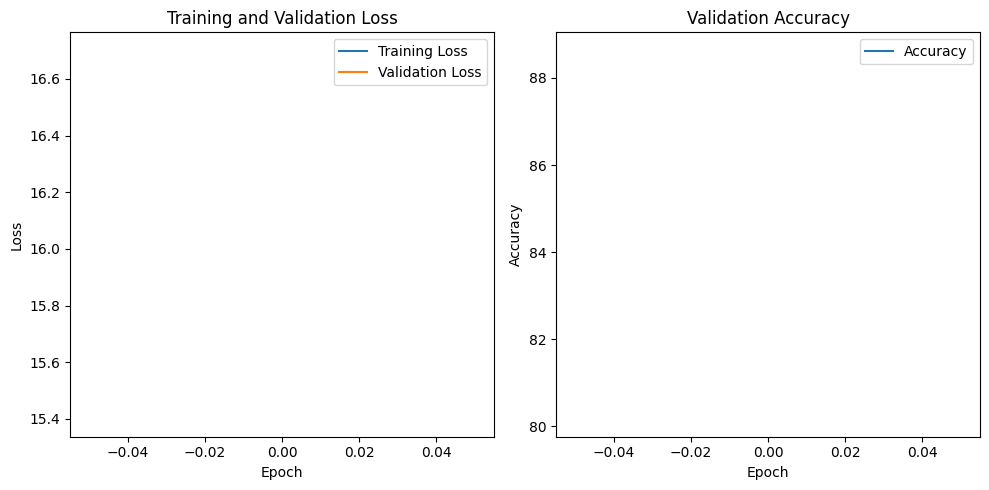

In [16]:
train_and_plot(learning_rate=0.1, batch_size=64, epochs=1,save_path = "/kaggle/working/model_4.pth")

# Model Experiment Results Model 5

- **Configuration:** LR=0.001, Batch=32, Epochs=5
- **Epoch 1:**
  - **Training Loss:** 0.32, **Validation Loss:** 0.16
  - **Validation Accuracy:** 94.52%
- **Epoch 2:**
  - **Training Loss:** 0.17, **Validation Loss:** 0.12
  - **Validation Accuracy:** 95.71%
- **Epoch 3:**
  - **Training Loss:** 0.13, **Validation Loss:** 0.09
  - **Validation Accuracy:** 96.54%
- **Epoch 4:**
  - **Training Loss:** 0.08, **Validation Loss:** 0.05
  - **Validation Accuracy:** 97.74%
- **Epoch 5:**
  - **Training Loss:** 0.06, **Validation Loss:** 0.08
  - **Validation Accuracy:** 97.38%

Results after five epochs of training with a lower batch size. Noticeable improvement in accuracy with reduced batch size.


Epoch 1/5, Avg. Training Loss: 0.31588632577941533, Avg. Validation Loss: 0.16356922216989375, Accuracy: 94.52380952380952%
Epoch 2/5, Avg. Training Loss: 0.16703173023692908, Avg. Validation Loss: 0.12057268912839289, Accuracy: 95.71428571428572%
Epoch 3/5, Avg. Training Loss: 0.13088518508843014, Avg. Validation Loss: 0.09399614461559665, Accuracy: 96.54761904761905%
Epoch 4/5, Avg. Training Loss: 0.08349784609107744, Avg. Validation Loss: 0.05876820084759621, Accuracy: 97.73809523809524%
Epoch 5/5, Avg. Training Loss: 0.06102504004125616, Avg. Validation Loss: 0.07634790635158963, Accuracy: 97.38095238095238%


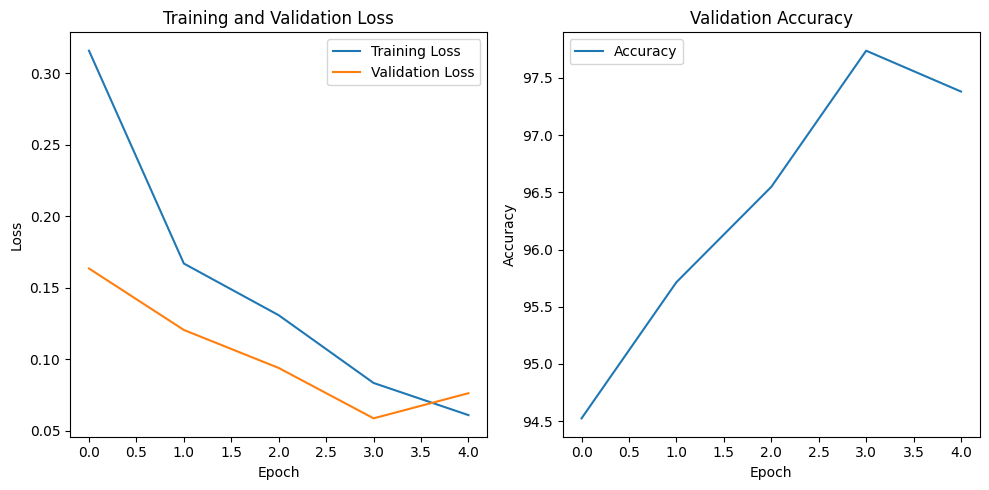

In [17]:
train_and_plot(learning_rate=0.001, batch_size=32, epochs=5,save_path = "/kaggle/working/model_5.pth")